# Neural contextualization with cytoarchitecture

### Libraries

In [7]:
import os
import glob
import nibabel as nb
import scipy.stats
import scipy as sp
from scipy.interpolate import interp1d
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask
from brainspace.mesh.mesh_creation import build_polydata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import copy
from brainstat.datasets import fetch_mask
import cmocean
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

### Load surfaces and masks

In [4]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Inflated fsLR-5k surfaces
f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

### Load intensity profiles

In [118]:
BBswm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/BB_IPs.npy') # BigBrain SWM intensity profiles
ABfswm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/AHEAD_Bieloschowsky_FS.npy') # Ahead-Bielschowsky SWM intensity profiles
APfswm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/AHEAD_Parvalbumin_FS.npy') # Ahead-Parvalbumin SWM intensity profiles
T1map_swm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_T1map_swmIP.npy') # T1 map SWM intensity profiles
MTSAT_swm_int = np.load('/host/verges/tank/data/youngeun/myjupyter/array/PNC-10sub_MTsat_swmIP.npy') # MTsat SWM intensity profiles

### Functions

## F1: Plotting smoothed profiles of filtered intensity maps based on cytoarchitectonic atlases
Before running the code, make sure to load the required atlas (`mesu_5k_round` or `eco_5k_round`) as loaded in the code below.

In [154]:
def plot_smoothed_profiles(mask_round, intensity_map, xlim, figsize=(6, 7)):
    """
    Plot smoothed profiles of filtered intensity maps.
    
    Parameters:
        mask_round (str): Type of mask ('Mesulam' or 'Economo').
        intensity_map (str): Type of intensity map ('T1map', 'MTSAT', 'BigBrain', 'Bielschowsky', 'Parvalbumin').
        xlim (tuple): X-axis limits for the plot.
        figsize (tuple): Figure size.
    """

    # Intensity map dictionary
    intensity_maps = {'T1map': T1map_swm_int, 'MTSAT': MTSAT_swm_int, 'BigBrain': BBswm_int, 'Bielschowsky': ABfswm_int, 'Parvalbumin': APfswm_int}
    
    # Mask and color settings based on mask_round type
    mask_settings = {'Mesulam': {'mask': mesu_5k_round, 'x': 5, 'colors': ['#455d9cff', '#00a09dff', '#31e363ff', 'gold']},
        'Economo': {'mask': eco_5k_round, 'x': 8, 'colors': ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', 'lightgray']}}

    # Validate inputs
    if mask_round not in mask_settings or intensity_map not in intensity_maps:
        raise ValueError("Invalid mask_round or intensity_map type.")
    
    # Deep copy of data
    IM = copy.deepcopy(intensity_maps[intensity_map])
    mask_data = copy.deepcopy(mask_settings[mask_round]['mask'])
    x = mask_settings[mask_round]['x']
    colors_profiles = mask_settings[mask_round]['colors']
    
    # Flip image for BigBrain, Bielschowsky, and Parvalbumin
    if intensity_map in ['BigBrain', 'Bielschowsky', 'Parvalbumin']:
        IM = np.flip(IM, axis=0)

    # Create filtered maps
    filtered_maps = {value: np.where(mask_data == value, IM, np.nan) for value in range(x)}
    
    # Compute mean values
    mean_values_dict = {key: np.nanmean(filtered_maps[key], axis=1) for key in range(1, x)}

    # Plot
    plt.figure(figsize=figsize)

    # Smoothed profiles
    smoothed_profiles = []
    x_values = np.arange(mean_values_dict[1].shape[0])

    for key in mean_values_dict:
        if intensity_map in ['T1map', 'MTSAT']:
            f = interp1d(x_values, mean_values_dict[key], kind='quadratic')
            x_interp = np.linspace(0, len(mean_values_dict[key]) - 1, 100)
            y_interp = f(x_interp)
        else:
            smoothed_data = gaussian_filter1d(mean_values_dict[key], sigma=2)
            f = interp1d(x_values, smoothed_data, kind='cubic')
            x_interp = np.linspace(0, len(smoothed_data) - 1, 500)
            y_interp = f(x_interp)

        smoothed_profiles.append(y_interp)

    # Plot profiles
    for smoothed_profile, color in zip(smoothed_profiles, colors_profiles):
        plt.plot(smoothed_profile, x_interp, color=color, linewidth=8)

    # Add horizontal red lines at specific positions
    hlines = { 'T1map': [5, 10], 'MTSAT': [5, 10], 'BigBrain': [17, 33], 'Bielschowsky': [17, 33], 'Parvalbumin': [17, 33] }
    
    for h in hlines[intensity_map]:
        plt.axhline(y=h, color='red', linestyle='--', linewidth=2)

    # Set plot limits and labels
    plt.xlim(xlim)
    plt.yticks([])
    plt.xticks(fontsize=15)
    plt.show()

## Mesulam Claases

In [121]:
mesuL_5k =  nb.load(micapipe + '/surfaces/fsLR-5k.L_mesulam.shape.gii').darrays[0].data
mesuR_5k =  nb.load(micapipe + '/surfaces/fsLR-5k.R_mesulam.shape.gii').darrays[0].data
mesu_5k = np.concatenate((mesuL_5k, mesuR_5k), axis=0)
mesu_5k_round = np.round(mesu_5k)

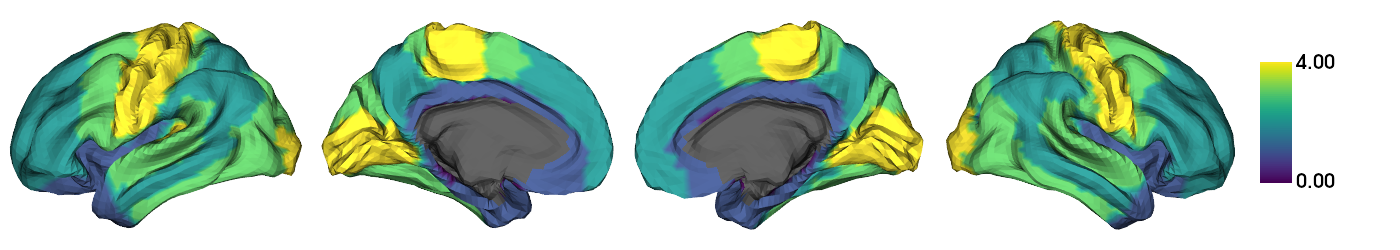

In [122]:
mesu_5k_round[mask_5k == False] = np.nan

# plot labels on surface
plot_hemispheres(f5k_lh, f5k_rh, mesu_5k_round, cmap='viridis', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

### BigBrain

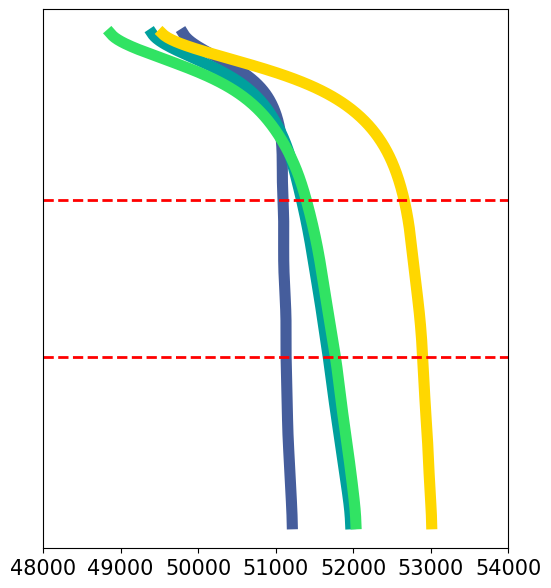

In [155]:
plot_smoothed_profiles(mask_round='Mesulam', intensity_map='BigBrain', xlim=(48000, 54000))

### AHEAD - Bielschowsky

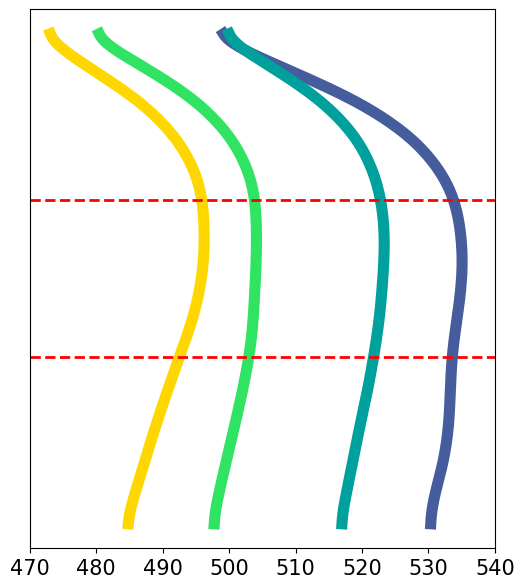

In [156]:
plot_smoothed_profiles(mask_round='Mesulam', intensity_map='Bielschowsky', xlim=(470, 540))

### AHEAD - Parvalbumin

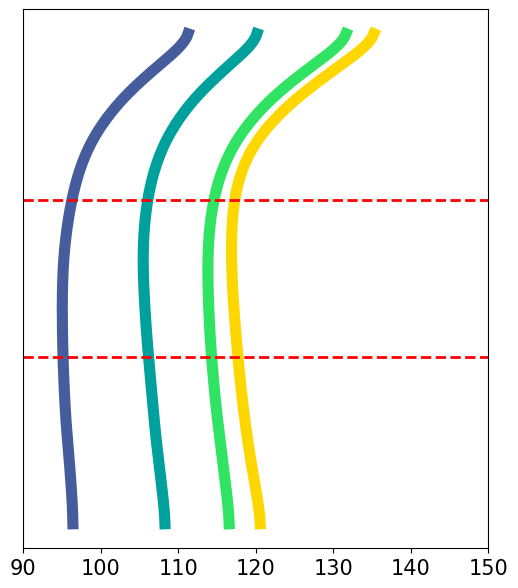

In [142]:
plot_smoothed_profiles(mask_round='Mesulam', intensity_map='Parvalbumin', xlim=(90, 150))

### T1 map

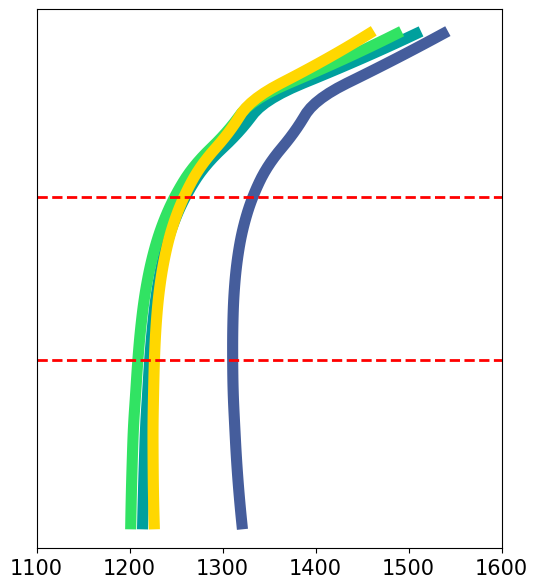

In [143]:
plot_smoothed_profiles(mask_round="Mesulam", intensity_map='T1map', xlim=(1100, 1600))

### MTsat

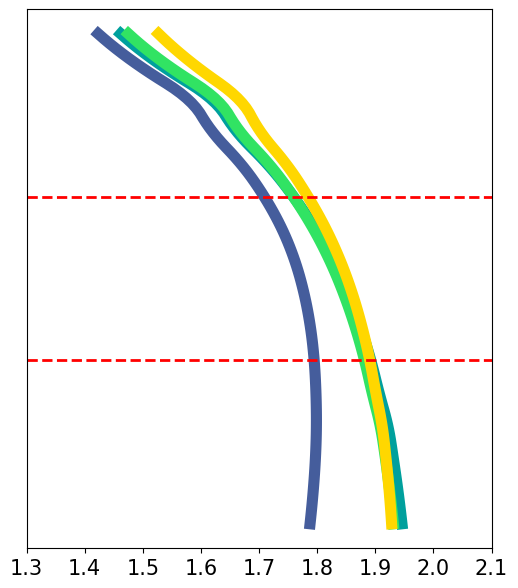

In [145]:
plot_smoothed_profiles(mask_round="Mesulam", intensity_map='MTSAT', xlim=(1.3, 2.1))

## Von Economo classes

In [27]:
ecoL_5k =  nb.load('/host/percy/local_raid/youngeun/from_mica1/parc/economo_fsLR5k.L.shape.gii').darrays[0].data
ecoR_5k =  nb.load('/host/percy/local_raid/youngeun/from_mica1/parc/economo_fsLR5k.R.shape.gii').darrays[0].data
eco_5k = np.concatenate((ecoL_5k, ecoR_5k), axis=0)
eco_5k_round = np.round(eco_5k)

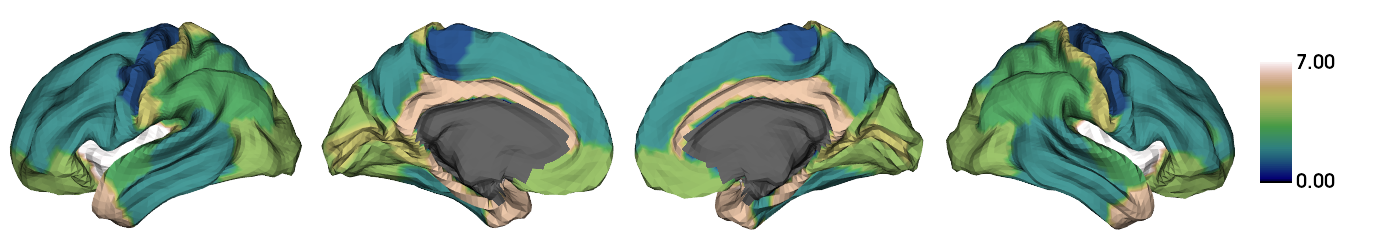

In [28]:
eco_5k_round[mask_5k == False] = np.nan

# plot labels on surface
plot_hemispheres(f5k_lh, f5k_rh, eco_5k_round, cmap='gist_earth', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

### BigBrain

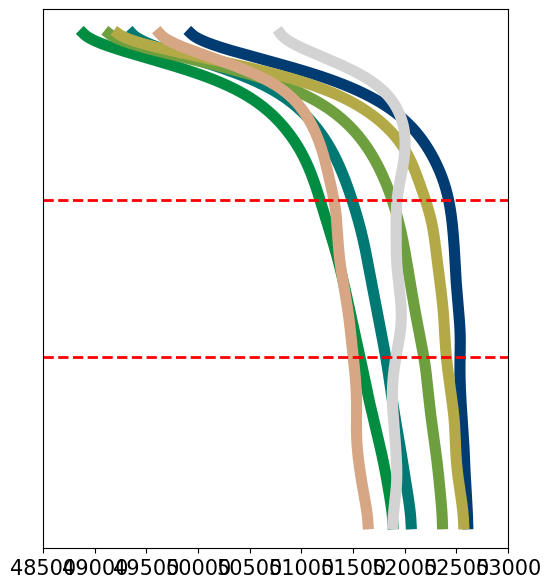

In [146]:
plot_smoothed_profiles(mask_round='Economo', intensity_map='BigBrain', xlim=(48500, 53000))

### AHEAD - Bielschowsky

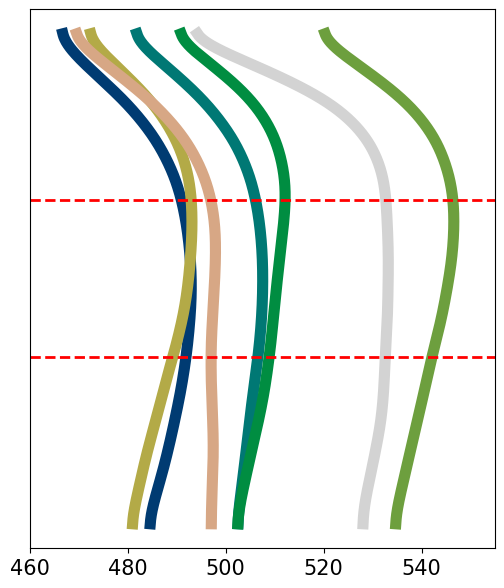

In [147]:
plot_smoothed_profiles(mask_round='Economo', intensity_map='Bielschowsky', xlim=(460, 555))

### AHEAD - Parvalbumin

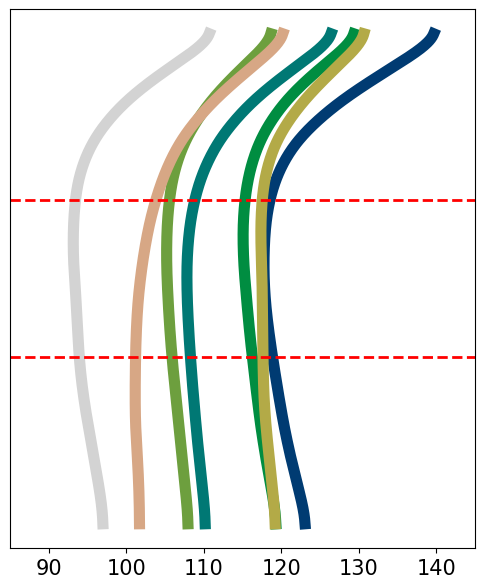

In [148]:
plot_smoothed_profiles(mask_round='Economo', intensity_map='Parvalbumin', xlim=(85, 145))

### T1 map

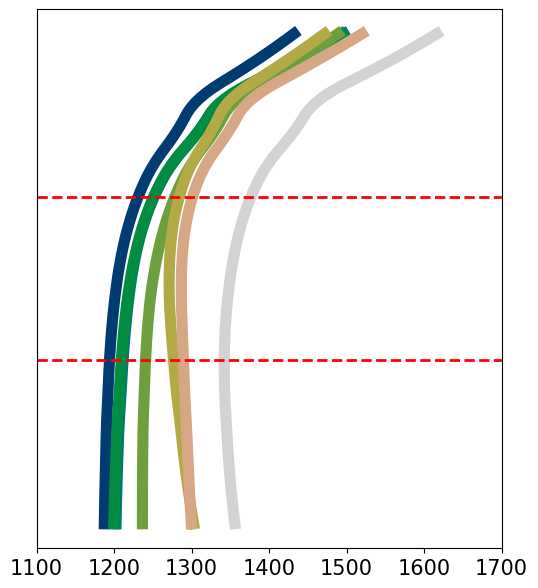

In [149]:
plot_smoothed_profiles(mask_round='Economo', intensity_map='T1map', xlim=(1100, 1700))

### MTsat

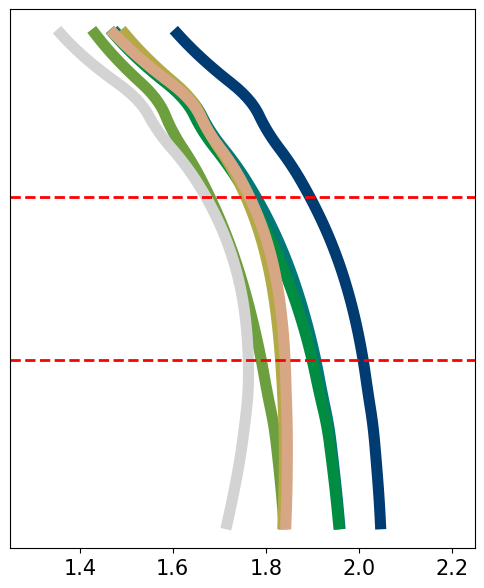

In [150]:
plot_smoothed_profiles(mask_round='Economo', intensity_map='MTSAT', xlim=(1.25, 2.25))